In [1]:
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pdb

# 0. Load data

Functions to load data:

In [2]:
def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, [size,size])
    return image

def load_data(root_path, size):
    images = []
    masks = []
    
    x=0
    
    for path in sorted(glob.glob(root_path)):
        if 'Zone.Identifier' in path:
            continue
        else:
            image = load_image(path, size)
            
            if 'mask' in path:
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)   # shape: (size,size,3) -> (size,size,1)
                image = image/255.
                if x:
                    masks[-1] += image
                    masks[-1] = np.array(masks[-1]>.5, dtype='float64')
                else:
                    masks.append(image)
                    x = 1
            else:
                image = image/255.
                images.append(image)
                x=0
    return np.array(images), np.array(masks)

Load data:

In [3]:
root_path = 'data/images/*/*'
size=128

X, y = load_data(root_path, size)


# 1. EDA

In [4]:
categories = ['benign', 'malignant', 'normal']
dict = {}
for category in categories:
    dict[category] = [
        path for path in sorted(glob.glob(f'data/images/{category}/*')) if ('Zone.Identifier' not in path) and ('mask' not in path)
    ]


In [5]:
benign_len = len(dict['benign'])
malignant_len = len(dict['malignant'])
normal_len = len(dict['normal'])
all_len = benign_len + malignant_len + normal_len

Text(0.5, 1.0, 'Number of images in each class')

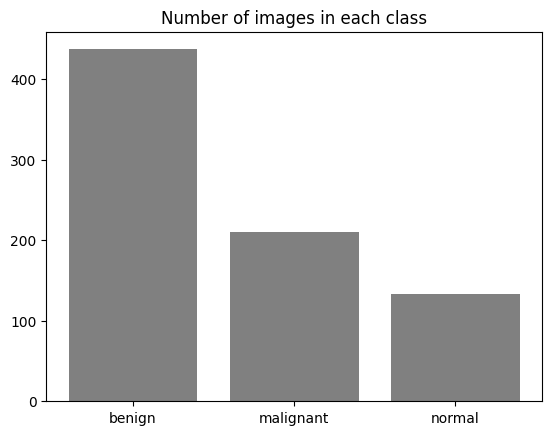

In [6]:
plt.bar(categories, [benign_len, malignant_len, normal_len], color='grey')
plt.title('Number of images in each class')

In [7]:
import tensorflow as tf

2023-05-08 16:43:33.961638: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 16:43:35.611781: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/saori/.pyenv/versions/3.10.6/envs/breast-ultrasound/lib/python3.10/site-packages/cv2/../../lib64:
2023-05-08 16:43:35.611859: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-08 16:43:35.716559: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory f

2023-05-08 16:43:43.699363: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/saori/.pyenv/versions/3.10.6/envs/breast-ultrasound/lib/python3.10/site-packages/cv2/../../lib64:
2023-05-08 16:43:43.700672: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-08 16:43:43.700739: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Chau): /proc/driver/nvidia/version does not exist
2023-05-08 16:43:43.704995: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler fla

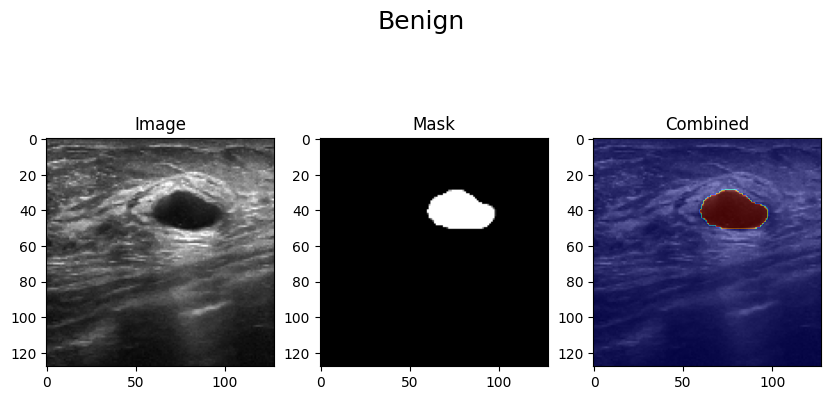

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(10,5))
fig.suptitle('Benign', fontsize=18)

i = np.random.randint(0, benign_len)

axs[0].imshow(X[i])
axs[0].set_title('Image')

axs[1].imshow(y[i], cmap='gray')
axs[1].set_title('Mask')

axs[2].imshow(X[i])
axs[2].imshow(tf.squeeze(y[i]), alpha=.5, cmap='jet')
axs[2].set_title('Combined')

plt.show()


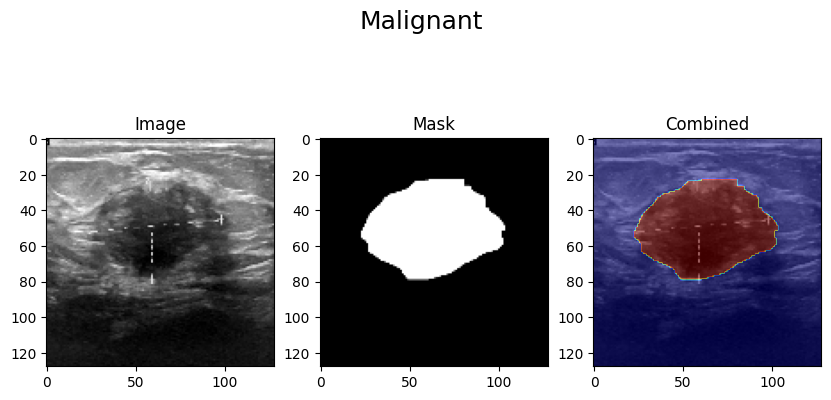

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(10,5))
fig.suptitle('Malignant', fontsize=18)

i = np.random.randint(benign_len, benign_len+malignant_len)

axs[0].imshow(X[i])
axs[0].set_title('Image')

axs[1].imshow(y[i], cmap='gray')
axs[1].set_title('Mask')

axs[2].imshow(X[i])
axs[2].imshow(tf.squeeze(y[i]), alpha=.5, cmap='jet')
axs[2].set_title('Combined')

plt.show()


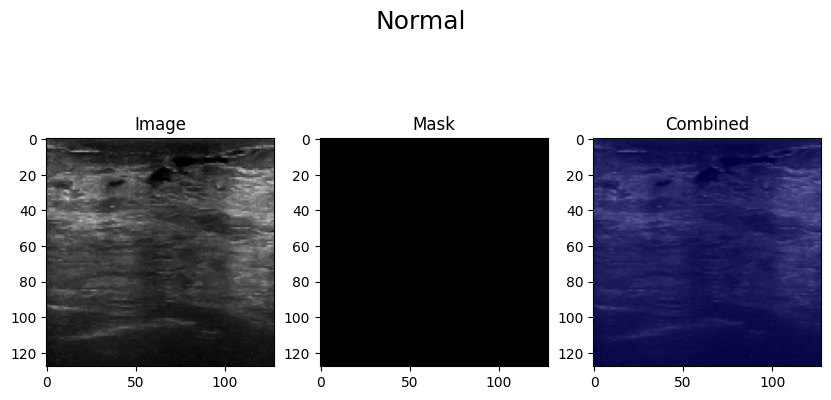

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(10,5))
fig.suptitle('Normal', fontsize=18)

i = np.random.randint(benign_len+malignant_len, all_len)

axs[0].imshow(X[i])
axs[0].set_title('Image')

axs[1].imshow(y[i], cmap='gray')
axs[1].set_title('Mask')

axs[2].imshow(X[i])
axs[2].imshow(tf.squeeze(y[i]), alpha=.5, cmap='jet')
axs[2].set_title('Combined')

plt.show()


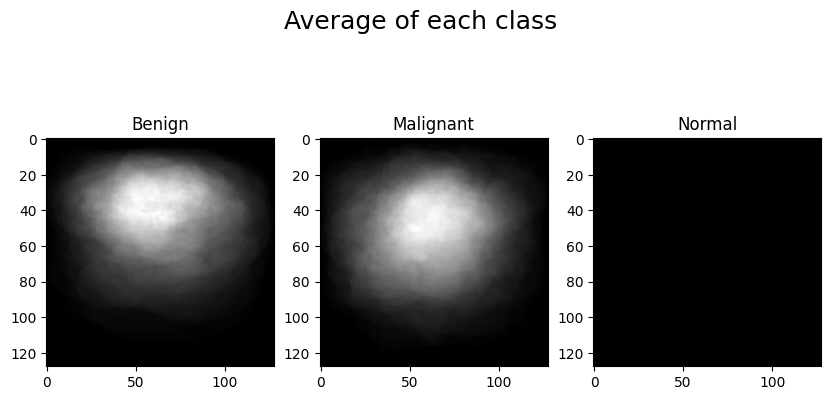

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(10,5))
fig.suptitle('Average of each class', fontsize=18)

axs[0].imshow(sum(y[0:benign_len])/benign_len, cmap='gray')
axs[0].set_title('Benign')

axs[1].imshow(sum(y[benign_len:benign_len+malignant_len])/malignant_len, cmap='gray')
axs[1].set_title('Malignant')

axs[2].imshow(sum(y[benign_len+malignant_len:all_len])/normal_len, cmap='gray')
axs[2].set_title('Normal')

plt.show()


# 2. Data prep for models

In [12]:
# X = np.expand_dims(X, -1)
y = np.expand_dims(y, -1)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (780, 128, 128, 3), y shape: (780, 128, 128, 1)


split train set, val set and test set

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=.5)

print(
    f"X train: {X_train.shape}, X val: {X_val.shape}, X test: {X_test.shape}, \
    y train: {y_train.shape}, y val: {y_val.shape}, y test: {y_test.shape}"
    )

X train: (624, 128, 128, 3), X val: (78, 128, 128, 3), X test: (78, 128, 128, 3),     y train: (624, 128, 128, 1), y val: (78, 128, 128, 1), y test: (78, 128, 128, 1)


# 3. Model building

In [15]:
mn_model = tf.keras.applications.MobileNetV2(
    input_shape = (128, 128, 3), include_top=False
)


In [16]:
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

mn_model_outputs = [mn_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=mn_model.input, outputs=mn_model_outputs)
down_stack.trainable = False

In [17]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),
    pix2pix.upsample(216, 3),
    pix2pix.upsample(127, 3),
    pix2pix.upsample(64, 3)
]

In [18]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    
    # downsampling
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    # upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x) 
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
        
    # last layer
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same'
    )
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

# 4. Model training

In [19]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels = OUTPUT_CLASSES)
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [20]:
sample_image, sample_mask = X[0], y[0]

In [21]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [22]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [25]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # clear_output(wait=True)
        show_predictions()
        print(f'\nSample prediction after epoch {epoch+1}\n')
    

In [27]:
EPOCHS = 20

model_history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=EPOCHS,
    callbacks=[DisplayCallback()],
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/20
1/1 [==============================] - 0s 171ms/steposs: 0.0999 - accuracy: 0.96


[array([[[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.65882353, 0.65882353, 0.65882353],
         [0.54901961, 0.54901961, 0.54901961],
         ...,
         [0.85490196, 0.85490196, 0.85490196],
         [0.81176471, 0.81176471, 0.81176471],
         [0.78431373, 0.78431373, 0.78431373]],
 
        [[0.04705882, 0.04705882, 0.04705882],
         [0.00392157, 0.00392157, 0.00392157],
         [0.17647059, 0.17647059, 0.17647059],
         ...,
         [0.76862745, 0.76862745, 0.76862745],
         [0.67843137, 0.67843137, 0.67843137],
         [0.6627451 , 0.6627451 , 0.6627451 ]],
 
        [[0.05882353, 0.05882353, 0.05882353],
         [0.00392157, 0.00392157, 0.00392157],
         [0.3254902 , 0.3254902 , 0.3254902 ],
         ...,
         [0.65490196, 0.65490196, 0.65490196],
         [0.61960784, 0.61960784, 0.61960784],
         [0.58431373, 0.58431373, 0.58431373]],
 
        ...,
 
        [[0.09019608, 0.09019608, 0.09019608],
         [0.09411765, 0.09411765, 0.09411


Sample prediction after epoch 1

39/39 [==============================] - 93s 2s/step - loss: 0.0999 - accuracy: 0.9609 - val_loss: 0.1527 - val_accuracy: 0.9460
Epoch 2/20
1/1 [==============================] - 0s 76ms/steploss: 0.0973 - accuracy: 0.96


[array([[[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.65882353, 0.65882353, 0.65882353],
         [0.54901961, 0.54901961, 0.54901961],
         ...,
         [0.85490196, 0.85490196, 0.85490196],
         [0.81176471, 0.81176471, 0.81176471],
         [0.78431373, 0.78431373, 0.78431373]],
 
        [[0.04705882, 0.04705882, 0.04705882],
         [0.00392157, 0.00392157, 0.00392157],
         [0.17647059, 0.17647059, 0.17647059],
         ...,
         [0.76862745, 0.76862745, 0.76862745],
         [0.67843137, 0.67843137, 0.67843137],
         [0.6627451 , 0.6627451 , 0.6627451 ]],
 
        [[0.05882353, 0.05882353, 0.05882353],
         [0.00392157, 0.00392157, 0.00392157],
         [0.3254902 , 0.3254902 , 0.3254902 ],
         ...,
         [0.65490196, 0.65490196, 0.65490196],
         [0.61960784, 0.61960784, 0.61960784],
         [0.58431373, 0.58431373, 0.58431373]],
 
        ...,
 
        [[0.09019608, 0.09019608, 0.09019608],
         [0.09411765, 0.09411765, 0.09411


Sample prediction after epoch 2

39/39 [==============================] - 146s 4s/step - loss: 0.0973 - accuracy: 0.9610 - val_loss: 0.1361 - val_accuracy: 0.9490
Epoch 3/20
1/1 [==============================] - 0s 134ms/steposs: 0.0917 - accuracy: 0.96


[array([[[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.65882353, 0.65882353, 0.65882353],
         [0.54901961, 0.54901961, 0.54901961],
         ...,
         [0.85490196, 0.85490196, 0.85490196],
         [0.81176471, 0.81176471, 0.81176471],
         [0.78431373, 0.78431373, 0.78431373]],
 
        [[0.04705882, 0.04705882, 0.04705882],
         [0.00392157, 0.00392157, 0.00392157],
         [0.17647059, 0.17647059, 0.17647059],
         ...,
         [0.76862745, 0.76862745, 0.76862745],
         [0.67843137, 0.67843137, 0.67843137],
         [0.6627451 , 0.6627451 , 0.6627451 ]],
 
        [[0.05882353, 0.05882353, 0.05882353],
         [0.00392157, 0.00392157, 0.00392157],
         [0.3254902 , 0.3254902 , 0.3254902 ],
         ...,
         [0.65490196, 0.65490196, 0.65490196],
         [0.61960784, 0.61960784, 0.61960784],
         [0.58431373, 0.58431373, 0.58431373]],
 
        ...,
 
        [[0.09019608, 0.09019608, 0.09019608],
         [0.09411765, 0.09411765, 0.09411


Sample prediction after epoch 3

39/39 [==============================] - 91s 2s/step - loss: 0.0917 - accuracy: 0.9639 - val_loss: 0.1372 - val_accuracy: 0.9491
Epoch 4/20
1/1 [==============================] - 0s 120ms/steposs: 0.0916 - accuracy: 0.96


[array([[[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.65882353, 0.65882353, 0.65882353],
         [0.54901961, 0.54901961, 0.54901961],
         ...,
         [0.85490196, 0.85490196, 0.85490196],
         [0.81176471, 0.81176471, 0.81176471],
         [0.78431373, 0.78431373, 0.78431373]],
 
        [[0.04705882, 0.04705882, 0.04705882],
         [0.00392157, 0.00392157, 0.00392157],
         [0.17647059, 0.17647059, 0.17647059],
         ...,
         [0.76862745, 0.76862745, 0.76862745],
         [0.67843137, 0.67843137, 0.67843137],
         [0.6627451 , 0.6627451 , 0.6627451 ]],
 
        [[0.05882353, 0.05882353, 0.05882353],
         [0.00392157, 0.00392157, 0.00392157],
         [0.3254902 , 0.3254902 , 0.3254902 ],
         ...,
         [0.65490196, 0.65490196, 0.65490196],
         [0.61960784, 0.61960784, 0.61960784],
         [0.58431373, 0.58431373, 0.58431373]],
 
        ...,
 
        [[0.09019608, 0.09019608, 0.09019608],
         [0.09411765, 0.09411765, 0.09411


Sample prediction after epoch 4

39/39 [==============================] - 101s 3s/step - loss: 0.0916 - accuracy: 0.9635 - val_loss: 0.1401 - val_accuracy: 0.9484
Epoch 5/20
1/1 [==============================] - 0s 243ms/steposs: 0.0872 - accuracy: 0.96


[array([[[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.65882353, 0.65882353, 0.65882353],
         [0.54901961, 0.54901961, 0.54901961],
         ...,
         [0.85490196, 0.85490196, 0.85490196],
         [0.81176471, 0.81176471, 0.81176471],
         [0.78431373, 0.78431373, 0.78431373]],
 
        [[0.04705882, 0.04705882, 0.04705882],
         [0.00392157, 0.00392157, 0.00392157],
         [0.17647059, 0.17647059, 0.17647059],
         ...,
         [0.76862745, 0.76862745, 0.76862745],
         [0.67843137, 0.67843137, 0.67843137],
         [0.6627451 , 0.6627451 , 0.6627451 ]],
 
        [[0.05882353, 0.05882353, 0.05882353],
         [0.00392157, 0.00392157, 0.00392157],
         [0.3254902 , 0.3254902 , 0.3254902 ],
         ...,
         [0.65490196, 0.65490196, 0.65490196],
         [0.61960784, 0.61960784, 0.61960784],
         [0.58431373, 0.58431373, 0.58431373]],
 
        ...,
 
        [[0.09019608, 0.09019608, 0.09019608],
         [0.09411765, 0.09411765, 0.09411


Sample prediction after epoch 5

39/39 [==============================] - 87s 2s/step - loss: 0.0872 - accuracy: 0.9651 - val_loss: 0.1375 - val_accuracy: 0.9481
Epoch 6/20
1/1 [==============================] - 0s 225ms/steposs: 0.0848 - accuracy: 0.96


[array([[[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.65882353, 0.65882353, 0.65882353],
         [0.54901961, 0.54901961, 0.54901961],
         ...,
         [0.85490196, 0.85490196, 0.85490196],
         [0.81176471, 0.81176471, 0.81176471],
         [0.78431373, 0.78431373, 0.78431373]],
 
        [[0.04705882, 0.04705882, 0.04705882],
         [0.00392157, 0.00392157, 0.00392157],
         [0.17647059, 0.17647059, 0.17647059],
         ...,
         [0.76862745, 0.76862745, 0.76862745],
         [0.67843137, 0.67843137, 0.67843137],
         [0.6627451 , 0.6627451 , 0.6627451 ]],
 
        [[0.05882353, 0.05882353, 0.05882353],
         [0.00392157, 0.00392157, 0.00392157],
         [0.3254902 , 0.3254902 , 0.3254902 ],
         ...,
         [0.65490196, 0.65490196, 0.65490196],
         [0.61960784, 0.61960784, 0.61960784],
         [0.58431373, 0.58431373, 0.58431373]],
 
        ...,
 
        [[0.09019608, 0.09019608, 0.09019608],
         [0.09411765, 0.09411765, 0.09411


Sample prediction after epoch 6

39/39 [==============================] - 146s 4s/step - loss: 0.0848 - accuracy: 0.9659 - val_loss: 0.1448 - val_accuracy: 0.9462
Epoch 7/20
1/1 [==============================] - 0s 114ms/steposs: 0.0875 - accuracy: 0.96


[array([[[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.65882353, 0.65882353, 0.65882353],
         [0.54901961, 0.54901961, 0.54901961],
         ...,
         [0.85490196, 0.85490196, 0.85490196],
         [0.81176471, 0.81176471, 0.81176471],
         [0.78431373, 0.78431373, 0.78431373]],
 
        [[0.04705882, 0.04705882, 0.04705882],
         [0.00392157, 0.00392157, 0.00392157],
         [0.17647059, 0.17647059, 0.17647059],
         ...,
         [0.76862745, 0.76862745, 0.76862745],
         [0.67843137, 0.67843137, 0.67843137],
         [0.6627451 , 0.6627451 , 0.6627451 ]],
 
        [[0.05882353, 0.05882353, 0.05882353],
         [0.00392157, 0.00392157, 0.00392157],
         [0.3254902 , 0.3254902 , 0.3254902 ],
         ...,
         [0.65490196, 0.65490196, 0.65490196],
         [0.61960784, 0.61960784, 0.61960784],
         [0.58431373, 0.58431373, 0.58431373]],
 
        ...,
 
        [[0.09019608, 0.09019608, 0.09019608],
         [0.09411765, 0.09411765, 0.09411


Sample prediction after epoch 7

39/39 [==============================] - 83s 2s/step - loss: 0.0875 - accuracy: 0.9650 - val_loss: 0.1472 - val_accuracy: 0.9497
Epoch 8/20
1/1 [==============================] - 0s 300ms/steposs: 0.0840 - accuracy: 0.96


[array([[[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.65882353, 0.65882353, 0.65882353],
         [0.54901961, 0.54901961, 0.54901961],
         ...,
         [0.85490196, 0.85490196, 0.85490196],
         [0.81176471, 0.81176471, 0.81176471],
         [0.78431373, 0.78431373, 0.78431373]],
 
        [[0.04705882, 0.04705882, 0.04705882],
         [0.00392157, 0.00392157, 0.00392157],
         [0.17647059, 0.17647059, 0.17647059],
         ...,
         [0.76862745, 0.76862745, 0.76862745],
         [0.67843137, 0.67843137, 0.67843137],
         [0.6627451 , 0.6627451 , 0.6627451 ]],
 
        [[0.05882353, 0.05882353, 0.05882353],
         [0.00392157, 0.00392157, 0.00392157],
         [0.3254902 , 0.3254902 , 0.3254902 ],
         ...,
         [0.65490196, 0.65490196, 0.65490196],
         [0.61960784, 0.61960784, 0.61960784],
         [0.58431373, 0.58431373, 0.58431373]],
 
        ...,
 
        [[0.09019608, 0.09019608, 0.09019608],
         [0.09411765, 0.09411765, 0.09411


Sample prediction after epoch 8

39/39 [==============================] - 109s 3s/step - loss: 0.0840 - accuracy: 0.9661 - val_loss: 0.1596 - val_accuracy: 0.9476
Epoch 9/20
1/1 [==============================] - 0s 275ms/steposs: 0.0833 - accuracy: 0.96


[array([[[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.65882353, 0.65882353, 0.65882353],
         [0.54901961, 0.54901961, 0.54901961],
         ...,
         [0.85490196, 0.85490196, 0.85490196],
         [0.81176471, 0.81176471, 0.81176471],
         [0.78431373, 0.78431373, 0.78431373]],
 
        [[0.04705882, 0.04705882, 0.04705882],
         [0.00392157, 0.00392157, 0.00392157],
         [0.17647059, 0.17647059, 0.17647059],
         ...,
         [0.76862745, 0.76862745, 0.76862745],
         [0.67843137, 0.67843137, 0.67843137],
         [0.6627451 , 0.6627451 , 0.6627451 ]],
 
        [[0.05882353, 0.05882353, 0.05882353],
         [0.00392157, 0.00392157, 0.00392157],
         [0.3254902 , 0.3254902 , 0.3254902 ],
         ...,
         [0.65490196, 0.65490196, 0.65490196],
         [0.61960784, 0.61960784, 0.61960784],
         [0.58431373, 0.58431373, 0.58431373]],
 
        ...,
 
        [[0.09019608, 0.09019608, 0.09019608],
         [0.09411765, 0.09411765, 0.09411


Sample prediction after epoch 9

39/39 [==============================] - 171s 4s/step - loss: 0.0833 - accuracy: 0.9667 - val_loss: 0.1423 - val_accuracy: 0.9482
Epoch 10/20
1/1 [==============================] - 0s 238ms/steposs: 0.0773 - accuracy: 0.96


[array([[[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.65882353, 0.65882353, 0.65882353],
         [0.54901961, 0.54901961, 0.54901961],
         ...,
         [0.85490196, 0.85490196, 0.85490196],
         [0.81176471, 0.81176471, 0.81176471],
         [0.78431373, 0.78431373, 0.78431373]],
 
        [[0.04705882, 0.04705882, 0.04705882],
         [0.00392157, 0.00392157, 0.00392157],
         [0.17647059, 0.17647059, 0.17647059],
         ...,
         [0.76862745, 0.76862745, 0.76862745],
         [0.67843137, 0.67843137, 0.67843137],
         [0.6627451 , 0.6627451 , 0.6627451 ]],
 
        [[0.05882353, 0.05882353, 0.05882353],
         [0.00392157, 0.00392157, 0.00392157],
         [0.3254902 , 0.3254902 , 0.3254902 ],
         ...,
         [0.65490196, 0.65490196, 0.65490196],
         [0.61960784, 0.61960784, 0.61960784],
         [0.58431373, 0.58431373, 0.58431373]],
 
        ...,
 
        [[0.09019608, 0.09019608, 0.09019608],
         [0.09411765, 0.09411765, 0.09411


Sample prediction after epoch 10

39/39 [==============================] - 166s 4s/step - loss: 0.0773 - accuracy: 0.9690 - val_loss: 0.1335 - val_accuracy: 0.9521
Epoch 11/20
1/1 [==============================] - 0s 236ms/steposs: 0.0745 - accuracy: 0.96


[array([[[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.65882353, 0.65882353, 0.65882353],
         [0.54901961, 0.54901961, 0.54901961],
         ...,
         [0.85490196, 0.85490196, 0.85490196],
         [0.81176471, 0.81176471, 0.81176471],
         [0.78431373, 0.78431373, 0.78431373]],
 
        [[0.04705882, 0.04705882, 0.04705882],
         [0.00392157, 0.00392157, 0.00392157],
         [0.17647059, 0.17647059, 0.17647059],
         ...,
         [0.76862745, 0.76862745, 0.76862745],
         [0.67843137, 0.67843137, 0.67843137],
         [0.6627451 , 0.6627451 , 0.6627451 ]],
 
        [[0.05882353, 0.05882353, 0.05882353],
         [0.00392157, 0.00392157, 0.00392157],
         [0.3254902 , 0.3254902 , 0.3254902 ],
         ...,
         [0.65490196, 0.65490196, 0.65490196],
         [0.61960784, 0.61960784, 0.61960784],
         [0.58431373, 0.58431373, 0.58431373]],
 
        ...,
 
        [[0.09019608, 0.09019608, 0.09019608],
         [0.09411765, 0.09411765, 0.09411


Sample prediction after epoch 11

39/39 [==============================] - 174s 4s/step - loss: 0.0745 - accuracy: 0.9698 - val_loss: 0.1596 - val_accuracy: 0.9486
Epoch 12/20
1/1 [==============================] - 0s 159ms/steposs: 0.0732 - accuracy: 0.97


[array([[[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.65882353, 0.65882353, 0.65882353],
         [0.54901961, 0.54901961, 0.54901961],
         ...,
         [0.85490196, 0.85490196, 0.85490196],
         [0.81176471, 0.81176471, 0.81176471],
         [0.78431373, 0.78431373, 0.78431373]],
 
        [[0.04705882, 0.04705882, 0.04705882],
         [0.00392157, 0.00392157, 0.00392157],
         [0.17647059, 0.17647059, 0.17647059],
         ...,
         [0.76862745, 0.76862745, 0.76862745],
         [0.67843137, 0.67843137, 0.67843137],
         [0.6627451 , 0.6627451 , 0.6627451 ]],
 
        [[0.05882353, 0.05882353, 0.05882353],
         [0.00392157, 0.00392157, 0.00392157],
         [0.3254902 , 0.3254902 , 0.3254902 ],
         ...,
         [0.65490196, 0.65490196, 0.65490196],
         [0.61960784, 0.61960784, 0.61960784],
         [0.58431373, 0.58431373, 0.58431373]],
 
        ...,
 
        [[0.09019608, 0.09019608, 0.09019608],
         [0.09411765, 0.09411765, 0.09411


Sample prediction after epoch 12

39/39 [==============================] - 159s 4s/step - loss: 0.0732 - accuracy: 0.9701 - val_loss: 0.1602 - val_accuracy: 0.9493
Epoch 13/20
1/1 [==============================] - 0s 198ms/steposs: 0.0732 - accuracy: 0.97


[array([[[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.65882353, 0.65882353, 0.65882353],
         [0.54901961, 0.54901961, 0.54901961],
         ...,
         [0.85490196, 0.85490196, 0.85490196],
         [0.81176471, 0.81176471, 0.81176471],
         [0.78431373, 0.78431373, 0.78431373]],
 
        [[0.04705882, 0.04705882, 0.04705882],
         [0.00392157, 0.00392157, 0.00392157],
         [0.17647059, 0.17647059, 0.17647059],
         ...,
         [0.76862745, 0.76862745, 0.76862745],
         [0.67843137, 0.67843137, 0.67843137],
         [0.6627451 , 0.6627451 , 0.6627451 ]],
 
        [[0.05882353, 0.05882353, 0.05882353],
         [0.00392157, 0.00392157, 0.00392157],
         [0.3254902 , 0.3254902 , 0.3254902 ],
         ...,
         [0.65490196, 0.65490196, 0.65490196],
         [0.61960784, 0.61960784, 0.61960784],
         [0.58431373, 0.58431373, 0.58431373]],
 
        ...,
 
        [[0.09019608, 0.09019608, 0.09019608],
         [0.09411765, 0.09411765, 0.09411


Sample prediction after epoch 13

39/39 [==============================] - 105s 3s/step - loss: 0.0732 - accuracy: 0.9700 - val_loss: 0.1625 - val_accuracy: 0.9439
Epoch 14/20
1/1 [==============================] - 0s 63ms/steploss: 0.0729 - accuracy: 0.97


[array([[[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.65882353, 0.65882353, 0.65882353],
         [0.54901961, 0.54901961, 0.54901961],
         ...,
         [0.85490196, 0.85490196, 0.85490196],
         [0.81176471, 0.81176471, 0.81176471],
         [0.78431373, 0.78431373, 0.78431373]],
 
        [[0.04705882, 0.04705882, 0.04705882],
         [0.00392157, 0.00392157, 0.00392157],
         [0.17647059, 0.17647059, 0.17647059],
         ...,
         [0.76862745, 0.76862745, 0.76862745],
         [0.67843137, 0.67843137, 0.67843137],
         [0.6627451 , 0.6627451 , 0.6627451 ]],
 
        [[0.05882353, 0.05882353, 0.05882353],
         [0.00392157, 0.00392157, 0.00392157],
         [0.3254902 , 0.3254902 , 0.3254902 ],
         ...,
         [0.65490196, 0.65490196, 0.65490196],
         [0.61960784, 0.61960784, 0.61960784],
         [0.58431373, 0.58431373, 0.58431373]],
 
        ...,
 
        [[0.09019608, 0.09019608, 0.09019608],
         [0.09411765, 0.09411765, 0.09411


Sample prediction after epoch 14

39/39 [==============================] - 91s 2s/step - loss: 0.0729 - accuracy: 0.9701 - val_loss: 0.1562 - val_accuracy: 0.9477
Epoch 15/20
1/1 [==============================] - 0s 109ms/steposs: 0.0669 - accuracy: 0.97


[array([[[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.65882353, 0.65882353, 0.65882353],
         [0.54901961, 0.54901961, 0.54901961],
         ...,
         [0.85490196, 0.85490196, 0.85490196],
         [0.81176471, 0.81176471, 0.81176471],
         [0.78431373, 0.78431373, 0.78431373]],
 
        [[0.04705882, 0.04705882, 0.04705882],
         [0.00392157, 0.00392157, 0.00392157],
         [0.17647059, 0.17647059, 0.17647059],
         ...,
         [0.76862745, 0.76862745, 0.76862745],
         [0.67843137, 0.67843137, 0.67843137],
         [0.6627451 , 0.6627451 , 0.6627451 ]],
 
        [[0.05882353, 0.05882353, 0.05882353],
         [0.00392157, 0.00392157, 0.00392157],
         [0.3254902 , 0.3254902 , 0.3254902 ],
         ...,
         [0.65490196, 0.65490196, 0.65490196],
         [0.61960784, 0.61960784, 0.61960784],
         [0.58431373, 0.58431373, 0.58431373]],
 
        ...,
 
        [[0.09019608, 0.09019608, 0.09019608],
         [0.09411765, 0.09411765, 0.09411


Sample prediction after epoch 15

39/39 [==============================] - 41s 1s/step - loss: 0.0669 - accuracy: 0.9725 - val_loss: 0.1479 - val_accuracy: 0.9504
Epoch 16/20
1/1 [==============================] - 0s 66ms/steploss: 0.0679 - accuracy: 0.97


[array([[[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.65882353, 0.65882353, 0.65882353],
         [0.54901961, 0.54901961, 0.54901961],
         ...,
         [0.85490196, 0.85490196, 0.85490196],
         [0.81176471, 0.81176471, 0.81176471],
         [0.78431373, 0.78431373, 0.78431373]],
 
        [[0.04705882, 0.04705882, 0.04705882],
         [0.00392157, 0.00392157, 0.00392157],
         [0.17647059, 0.17647059, 0.17647059],
         ...,
         [0.76862745, 0.76862745, 0.76862745],
         [0.67843137, 0.67843137, 0.67843137],
         [0.6627451 , 0.6627451 , 0.6627451 ]],
 
        [[0.05882353, 0.05882353, 0.05882353],
         [0.00392157, 0.00392157, 0.00392157],
         [0.3254902 , 0.3254902 , 0.3254902 ],
         ...,
         [0.65490196, 0.65490196, 0.65490196],
         [0.61960784, 0.61960784, 0.61960784],
         [0.58431373, 0.58431373, 0.58431373]],
 
        ...,
 
        [[0.09019608, 0.09019608, 0.09019608],
         [0.09411765, 0.09411765, 0.09411


Sample prediction after epoch 16

39/39 [==============================] - 39s 1s/step - loss: 0.0679 - accuracy: 0.9721 - val_loss: 0.1826 - val_accuracy: 0.9404
Epoch 17/20
1/1 [==============================] - 0s 63ms/steploss: 0.0646 - accuracy: 0.97


[array([[[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.65882353, 0.65882353, 0.65882353],
         [0.54901961, 0.54901961, 0.54901961],
         ...,
         [0.85490196, 0.85490196, 0.85490196],
         [0.81176471, 0.81176471, 0.81176471],
         [0.78431373, 0.78431373, 0.78431373]],
 
        [[0.04705882, 0.04705882, 0.04705882],
         [0.00392157, 0.00392157, 0.00392157],
         [0.17647059, 0.17647059, 0.17647059],
         ...,
         [0.76862745, 0.76862745, 0.76862745],
         [0.67843137, 0.67843137, 0.67843137],
         [0.6627451 , 0.6627451 , 0.6627451 ]],
 
        [[0.05882353, 0.05882353, 0.05882353],
         [0.00392157, 0.00392157, 0.00392157],
         [0.3254902 , 0.3254902 , 0.3254902 ],
         ...,
         [0.65490196, 0.65490196, 0.65490196],
         [0.61960784, 0.61960784, 0.61960784],
         [0.58431373, 0.58431373, 0.58431373]],
 
        ...,
 
        [[0.09019608, 0.09019608, 0.09019608],
         [0.09411765, 0.09411765, 0.09411


Sample prediction after epoch 17

39/39 [==============================] - 47s 1s/step - loss: 0.0646 - accuracy: 0.9735 - val_loss: 0.1567 - val_accuracy: 0.9507
Epoch 18/20
1/1 [==============================] - 0s 58ms/steploss: 0.0610 - accuracy: 0.97


[array([[[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.65882353, 0.65882353, 0.65882353],
         [0.54901961, 0.54901961, 0.54901961],
         ...,
         [0.85490196, 0.85490196, 0.85490196],
         [0.81176471, 0.81176471, 0.81176471],
         [0.78431373, 0.78431373, 0.78431373]],
 
        [[0.04705882, 0.04705882, 0.04705882],
         [0.00392157, 0.00392157, 0.00392157],
         [0.17647059, 0.17647059, 0.17647059],
         ...,
         [0.76862745, 0.76862745, 0.76862745],
         [0.67843137, 0.67843137, 0.67843137],
         [0.6627451 , 0.6627451 , 0.6627451 ]],
 
        [[0.05882353, 0.05882353, 0.05882353],
         [0.00392157, 0.00392157, 0.00392157],
         [0.3254902 , 0.3254902 , 0.3254902 ],
         ...,
         [0.65490196, 0.65490196, 0.65490196],
         [0.61960784, 0.61960784, 0.61960784],
         [0.58431373, 0.58431373, 0.58431373]],
 
        ...,
 
        [[0.09019608, 0.09019608, 0.09019608],
         [0.09411765, 0.09411765, 0.09411


Sample prediction after epoch 18

39/39 [==============================] - 39s 1s/step - loss: 0.0610 - accuracy: 0.9751 - val_loss: 0.1531 - val_accuracy: 0.9490
Epoch 19/20
1/1 [==============================] - 0s 98ms/steploss: 0.0571 - accuracy: 0.97


[array([[[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.65882353, 0.65882353, 0.65882353],
         [0.54901961, 0.54901961, 0.54901961],
         ...,
         [0.85490196, 0.85490196, 0.85490196],
         [0.81176471, 0.81176471, 0.81176471],
         [0.78431373, 0.78431373, 0.78431373]],
 
        [[0.04705882, 0.04705882, 0.04705882],
         [0.00392157, 0.00392157, 0.00392157],
         [0.17647059, 0.17647059, 0.17647059],
         ...,
         [0.76862745, 0.76862745, 0.76862745],
         [0.67843137, 0.67843137, 0.67843137],
         [0.6627451 , 0.6627451 , 0.6627451 ]],
 
        [[0.05882353, 0.05882353, 0.05882353],
         [0.00392157, 0.00392157, 0.00392157],
         [0.3254902 , 0.3254902 , 0.3254902 ],
         ...,
         [0.65490196, 0.65490196, 0.65490196],
         [0.61960784, 0.61960784, 0.61960784],
         [0.58431373, 0.58431373, 0.58431373]],
 
        ...,
 
        [[0.09019608, 0.09019608, 0.09019608],
         [0.09411765, 0.09411765, 0.09411


Sample prediction after epoch 19

39/39 [==============================] - 58s 1s/step - loss: 0.0571 - accuracy: 0.9766 - val_loss: 0.1507 - val_accuracy: 0.9515
Epoch 20/20
1/1 [==============================] - 0s 74ms/steploss: 0.0600 - accuracy: 0.97


[array([[[0.0627451 , 0.0627451 , 0.0627451 ],
         [0.65882353, 0.65882353, 0.65882353],
         [0.54901961, 0.54901961, 0.54901961],
         ...,
         [0.85490196, 0.85490196, 0.85490196],
         [0.81176471, 0.81176471, 0.81176471],
         [0.78431373, 0.78431373, 0.78431373]],
 
        [[0.04705882, 0.04705882, 0.04705882],
         [0.00392157, 0.00392157, 0.00392157],
         [0.17647059, 0.17647059, 0.17647059],
         ...,
         [0.76862745, 0.76862745, 0.76862745],
         [0.67843137, 0.67843137, 0.67843137],
         [0.6627451 , 0.6627451 , 0.6627451 ]],
 
        [[0.05882353, 0.05882353, 0.05882353],
         [0.00392157, 0.00392157, 0.00392157],
         [0.3254902 , 0.3254902 , 0.3254902 ],
         ...,
         [0.65490196, 0.65490196, 0.65490196],
         [0.61960784, 0.61960784, 0.61960784],
         [0.58431373, 0.58431373, 0.58431373]],
 
        ...,
 
        [[0.09019608, 0.09019608, 0.09019608],
         [0.09411765, 0.09411765, 0.09411


Sample prediction after epoch 20

39/39 [==============================] - 63s 2s/step - loss: 0.0600 - accuracy: 0.9753 - val_loss: 0.1593 - val_accuracy: 0.9515
